# Imports

In [1]:
import cv2
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pylab import rcParams
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Methods

In [2]:
#-- Dataset loader --#

def fetch_files(dir:str, filetype:list, arr:list = []):
    with os.scandir(dir) as content:
        for item in content:
            if os.path.isdir(dir + '/' + item.name):
                arr = fetch_files(dir + '/' + item.name, filetype, arr)
            elif item.name.split('.')[-1] in filetype:
                arr.append(item)
    return arr

def load_dataset(arr:list):
    for i in arr:
        assert type(i) == os.DirEntry
    data = [cv2.cvtColor(cv2.imread(x.path), cv2.COLOR_BGR2RGB) for x in arr]
    label = [x.path.replace(x.name, '')[:-1].split('/')[-1] for x in arr]
    return data, label


#-- Data Processer --#

def center_crop_image(img):
    h, w = img.shape[:2]
    aspect = h/w
    if aspect > 1:
        offset = int(np.round((h / 2) - (w / 2)))
        return img[offset:w + offset, 0:w]
    else:
        offset = int(np.round((w / 2) - (h / 2)))
        return img[0:h, offset:h + offset]

def process_images(images, image_size):
    cropped_images = [center_crop_image(img) for img in images]
    resized_images = [cv2.resize(img, (image_size, image_size), cv2.INTER_AREA) for img in cropped_images]
    return resized_images


#-- Data visualizer --#

def visualizer(x, y=None, grid=None, font=None):
    if not font:
        font = {'font.family': 'Arial', 'font.size' : 12}
    rcParams.update(font)
    if not grid or 1 in grid:
        fig = plt.figure(figsize=(6,6))
        plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.imshow(x, cmap="Greys")
        if y: plt.title(y)
    else:
        fig, axes = plt.subplots(grid[0], grid[1],figsize=(10,10))
        for row in axes:
            for axe in row:
                axe.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
                r = np.random.randint(len(x))
                axe.imshow(x[r], cmap="Greys")
                if y: axe.set_title(y[r])
                #plt.tight_layout()
    plt.show()

# Config

In [3]:
dataset = 'B:/dataset/size224_seed0_conf0.8_rot4-4'

image_size = 224

random_seed = 0

# Load dataset

In [4]:
data, label = load_dataset(fetch_files(dataset, filetype=['jpg']))

In [5]:
data = process_images(data, image_size)

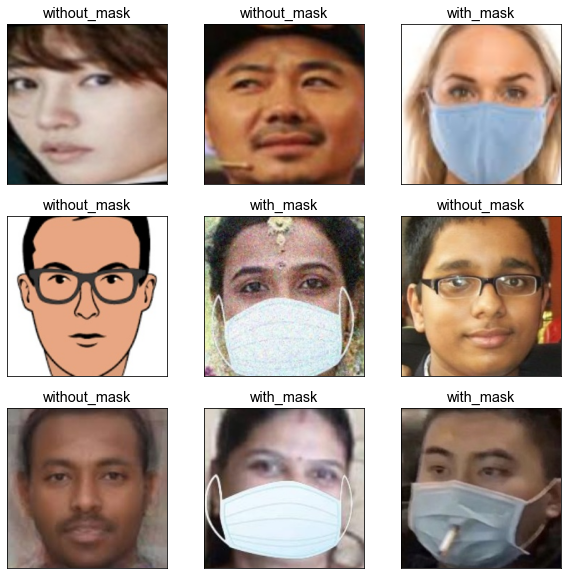

In [6]:
visualizer(data, label, grid=(3,3))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=random_seed)

In [8]:
# Reshape X
X_train = np.array(X_train).reshape(-1, image_size, image_size, 3)
X_test = np.array(X_test).reshape(-1, image_size, image_size, 3)

# Categorize y
unique_labels = []
[unique_labels.append(x) for x in label if x not in unique_labels]
y_train = np.array([unique_labels.index(x) for x in y_train])
y_test = np.array([unique_labels.index(x) for x in y_test])

# encode the y labels
categories = len(unique_labels)
y_train, y_test = to_categorical(y_train, categories), to_categorical(y_test, categories)

# CNN

### MobileNet

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, AveragePooling2D

def init_model(seed):
    model = Sequential()
    model.add(MobileNetV2(weights='imagenet', input_shape=(image_size, image_size, 3), include_top=False))
    # model.add(Flatten())

    model.add(AveragePooling2D(pool_size=(7,7)))
    model.add(Flatten())
    model.add(Dense(128, 'relu'))
    model.add(Dropout(0.5, seed=seed))

    model.add(Dense(categories, 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

model = init_model(random_seed)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 2,388,098
Non-trainable params: 34,112
_________________________________________

### AlexNet (no transfer-learning)

In [10]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
# from keras.optimizers import Adam

# # AlexNet
# def init_model(seed):
#     model = Sequential()
    
#     # 1st Convelutional Layer
#     model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='same',
#     input_shape=(image_size,image_size,3)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#     # 2nd Convelutional Layer
#     model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#     # 3rd Convelutional Layer
#     model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))

#     # 4th Convelutional Layer
#     model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))

#     # 5th Convelutional Layer
#     model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#     # Fully connected layer
#     model.add(Flatten())
#     model.add(Dense(4096))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.4, seed=seed))

#     # 2nd Connected Layer
#     model.add(Dense(4096))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.4, seed=seed))

#     # 3nd Connected Layer
#     model.add(Dense(1000))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.4, seed=seed))

#     # Output
#     model.add(Dense(categories))
#     model.add(BatchNormalization())
#     model.add(Activation('softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
#     return model
    
# model = init_model(random_seed)
# model.summary()

### ResNet101V2

In [11]:
# from tensorflow.keras.applications import ResNet101V2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout, AveragePooling2D

# def init_model(seed):
#     model = Sequential()
#     model.add(ResNet101V2(weights='imagenet', input_shape=(image_size, image_size, 3), include_top=False))
#     # model.add(Flatten())

#     model.add(AveragePooling2D(pool_size=(7,7)))
#     model.add(Flatten())
#     model.add(Dense(128, 'relu'))
#     model.add(Dropout(0.5, seed=seed))

#     model.add(Dense(categories, 'softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
#     return model

# model = init_model(random_seed)
# model.summary()

# Training

In [12]:
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
182/182 [==============================] - 54s 217ms/step - loss: 0.0919 - accuracy: 0.9688
Epoch 2/20
182/182 [==============================] - 40s 219ms/step - loss: 0.0465 - accuracy: 0.9879
Epoch 3/20
182/182 [==============================] - 40s 219ms/step - loss: 0.0259 - accuracy: 0.9919
Epoch 4/20
182/182 [==============================] - 41s 224ms/step - loss: 0.0252 - accuracy: 0.9924
Epoch 5/20
182/182 [==============================] - 40s 222ms/step - loss: 0.0204 - accuracy: 0.9938
Epoch 6/20
182/182 [==============================] - 40s 222ms/step - loss: 0.0263 - accuracy: 0.9924
Epoch 7/20
182/182 [==============================] - 40s 221ms/step - loss: 0.0319 - accuracy: 0.9928
Epoch 8/20
182/182 [==============================] - 40s 221ms/step - loss: 0.0233 - accuracy: 0.9936
Epoch 9/20
182/182 [==============================] - 40s 218ms/step - loss: 0.0413 - accuracy: 0.9879
Epoch 10/20
182/182 [==============================] - 39s 214ms/step - l

In [13]:
# result = []
# for _ in tqdm(range(10), desc='Traning'):
#     model = init_model(random_seed)
#     model.fit(X_train, y_train, epochs=30, verbose=0)
#     _, acc = model.evaluate(X_test, y_test, verbose=0)
#     result.append(acc)
# print(np.mean(result))

# Results

In [14]:
_, eval_accuracy = model.evaluate(X_test, y_test, verbose=2)

78/78 - 5s - loss: 0.1692 - accuracy: 0.9835


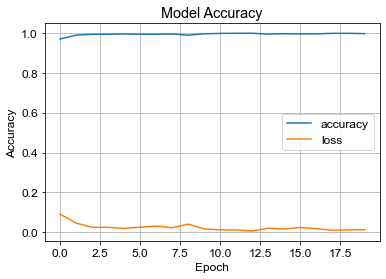

In [15]:
rcParams.update({'font.family': 'Arial', 'font.size' : 12})
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
# plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'])
plt.grid()
plt.show()

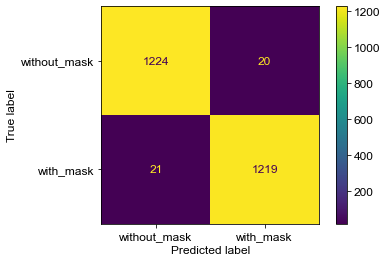

In [16]:
# Convert categorical back to integers
y_test_true = np.array([np.where(x == x.max())[0][0] for x in y_test])
y_test_pred = np.array([np.where(x == x.max())[0][0] for x in model.predict(X_test)])

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_true, y_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=unique_labels)
cmd.plot()

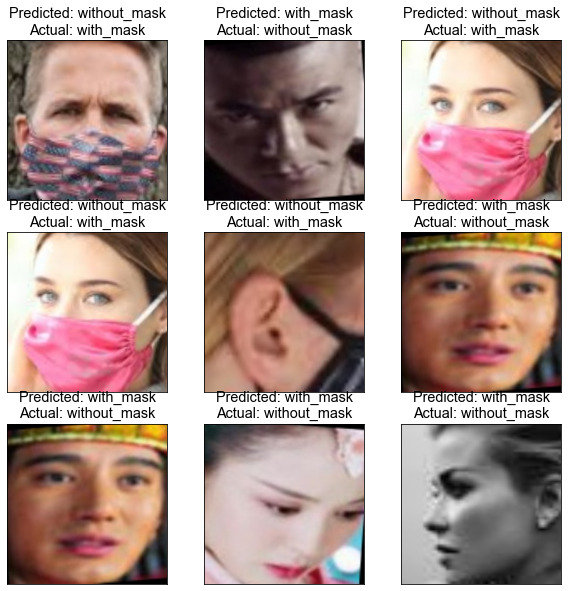

In [17]:
# Displays a sample of what the model got wrong
visualizer([x for c, x in enumerate(X_test) if y_test_pred[c] != y_test_true[c]], [f'Predicted: {unique_labels[y[0]]}\nActual: {unique_labels[y[1]]}' for c, y in enumerate(zip(y_test_pred, y_test_true)) if y_test_pred[c] != y_test_true[c]], grid=(3,3))

# System Test

In [18]:
import cv2
import os
import numpy as np
import time

def center_box(box):
    startX, startY, endX, endY = box.astype("int")
    h = endY - startY
    w = endX - startX
    aspect = h/w
    if aspect > 1:
        offset = int(np.round((h / 2) - (w / 2)))
        return startX - offset, startY, endX + offset, endY
    else:
        offset = int(np.round((w / 2) - (h / 2)))
        return startX, startY - offset, endX, endY + offset

def classify_image(interpreter, image):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_data = image
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Set to True if running on Raspberry Pi
arm = False

# Set working dir
# os.chdir(os.path.dirname(os.path.abspath(__file__)))

# Face detect model
prototxt_path = 'deploy.prototxt'
weights_path = 'res10_300x300_ssd_iter_140000_fp16.caffemodel'
face_detect = cv2.dnn.readNet(prototxt_path, weights_path)

# CNN
if arm:
    from tflite_runtime.interpreter import Interpreter
    model = Interpreter('model.tflite')
    model.allocate_tensors()
else: 
    # from tensorflow.keras.models import load_model
    # model_folder = 'model'
    # model = load_model(model_folder)
    pass

# Thermal camera
if arm:
    import board, busio
    import adafruit_mlx90640

    # Setup I2C
    i2c = busio.I2C(board.SCL, board.SDA, frequency=400_000)

    # Begin MLX90640 with I2C comm
    while True:
        try:
            mlx = adafruit_mlx90640.MLX90640(i2c)
            mlx.refresh_rate = adafruit_mlx90640.RefreshRate.REFRESH_8_HZ
            break
        # If there is a bad physical connection to the thermal camera 
        except ValueError:
            pass

# Image properties
image_size = 224

# Camera init
video_capture = cv2.VideoCapture(0)

# Used for fps calculation
time1 = 0
time2 = 0

# Main loop
while(video_capture.isOpened()):
    # Start timer for fps calculation
    time1 = time.time()

    # Read frame from camera
    ret, frame = video_capture.read()
    if not ret:
        break
    h, w = frame.shape[:2]

    if arm:
        # Setup array for sorting all 768 temperatures
        mlx_frame = np.zeros((24*32,))
        try:
            mlx.getFrame(mlx_frame)
        # If there is a bad physical connection to the thermal camera
        except OSError:
            pass

        # Reshape array to matrix
        t_frame = np.reshape(mlx_frame, (24,32))
        # Flip thermal frame
        t_frame = np.flip(t_frame, axis=0)
        # Upscale thermal frame to match camera
        t_frame = t_frame.repeat(20, axis=0).repeat(20, axis=1)

        # Create frame for display alongside camera frame
        # Normailize thermal frame
        t_frame_d = (t_frame - np.min(t_frame)) / np.ptp(t_frame)
        # Round all values in thermal frame
        t_frame_d = np.round(t_frame_d * 255, 0).astype(np.uint8)
        # Add dimensions to frame to make it appear as RGB
        t_frame_d = np.stack((t_frame_d,)*3, axis=-1)

        # Flip camera frame
        frame = cv2.flip(frame, -1)
        # Crop and resize camera frame to try and match thermal frame
        frame = cv2.resize(frame[20:400, 40:527], (640,480))

    # OpenCV DNN pre-processing
    blob = cv2.dnn.blobFromImage(frame, 1.0, (image_size, image_size))
    # Process the pre-processed frame & find faces
    face_detect.setInput(blob)
    faces = face_detect.forward()

    # For all faces detected in frame
    for i in range(0, faces.shape[2]):
        # Get the confidence that it is a face 
        confidence = faces[0, 0, i, 2]
        if confidence > 0.7:
            # Get coordinates for face
            box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
            startX, startY, endX, endY = center_box(box)

            # ensure the bounding boxes fall within the dimensions of the frame
            startX, startY = max(0, startX), max(0, startY)
            endX, endY = min(w - 1, endX), min(h - 1, endY)

            # Pre-process frame
            frame_crop = frame[startY:endY, startX:endX]
            frame_crop_resize = cv2.resize(frame_crop, (image_size, image_size), cv2.INTER_AREA)
            frame_crop_resize_reshape = np.array(frame_crop_resize, dtype=np.float32).reshape(-1, image_size, image_size, 3)
            
            # Make a prediction
            if arm:
                pred = classify_image(model, frame_crop_resize_reshape)
            else:
                pred = model.predict(frame_crop_resize_reshape)

            # Red, Green, Yellow
            color = [(0,0,255),(0,255,0),(128,128,0)]

            # Convert prediction to lables
            pred_index = np.argmax(pred[0])

            # Draw a rectangle around the faces with classification
            text = unique_labels[pred_index] + ' (' +  str(round(pred[0][pred_index] * 100)) + '%)'
            cv2.rectangle(frame, (startX, startY), (endX, endY), color[pred_index], 2)
            cv2.putText(frame, text, (startX, startY - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color[pred_index], 1, cv2.LINE_AA)

            if arm:
                # Crop thermal frame of face
                t_frame_d_crop = t_frame[startY:endY, startX:endX]
                # Calculate mean temperature of cropped thermal frame 
                temp = np.round(np.mean(t_frame_d_crop), 1)

                # Draw rectangle around thermal frame with temperature
                cv2.rectangle(t_frame_d, (startX, startY), (endX, endY), color, 2)
                cv2.putText(t_frame_d, str(temp), (startX, startY - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 1, cv2.LINE_AA)

    # Calculate fps
    fps = 1/(time1 - time2)
    time2 = time1
    # Draw fps on frame
    cv2.putText(frame, str(int(fps)) + 'fps', (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 1, cv2.LINE_AA)

    if arm:
        # Combine camera and thermal frame
        frame = np.concatenate((frame, t_frame_d), axis=0)
        
    # Display the resulting frame
    cv2.imshow('window', frame)
    
    # Press ESC to quit
    if cv2.waitKey(1) & 0xFF == 27:  
        break

video_capture.release()
cv2.destroyAllWindows()

# Save Model

In [19]:
model.save('model')

C:\tools\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [20]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)